##### **Imports**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  roc_curve, auc, precision_score

import warnings
warnings.filterwarnings("ignore")

colors = ['crimson','midnightblue', 'magenta','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

##### **Problem 1a**

Get data and separate into training/test sets

In [3]:
data = pd.read_csv('earning_potential_train_test.txt', sep=',',header=0)
data['label'] = data['earning'].apply(lambda x: 1 if x== ' >50K' else 0)

In [4]:
label_counts = data['label'].value_counts()
data.drop(columns=['label'], inplace=True)
ratio = label_counts[1]/label_counts[0]

print(f'There are {label_counts[1]} high-earners and {label_counts[0]} low-earners. This is a ratio of {ratio:.3}')
print(f'We choose a ratio of 54:46 training:test ratio, as this will give 502 test samples. The ratio above is also preserved')

There are 1091 high-earners and 3409 low-earners. This is a ratio of 0.32
We choose a ratio of 54:46 training:test ratio, as this will give 502 test samples. The ratio above is also preserved


Classifier

In [5]:
### Mask the data ie. split the data
high_earners = (data['earning'] == ' >50K')
low_earners = (data['earning'] == ' <=50K')

### Extract the feature columns
x_high = data.iloc[:,:4][high_earners]
x_low = data.iloc[:,:4][low_earners]

### Labels
y_high = np.ones(1091)
y_low = np.zeros(3409)

In [6]:
### Get data
x_high_training, x_high_testing, y_high_training, y_high_testing = train_test_split(x_high, y_high, test_size=0.46, random_state=42)
x_low_training, x_low_testing, y_low_training, y_low_testing = train_test_split(x_low, y_low, test_size=0.46, random_state=42)

# Prepare and combine the data sets
x_training = np.vstack([x_high_training, x_low_training])
x_testing = np.vstack([x_high_testing, x_low_testing])

y_training = np.hstack([y_high_training, y_low_training])
y_testing = np.hstack([y_high_testing, y_low_testing])

In [7]:
### Shuffle the data
indices_training = np.arange(len(y_training))
np.random.shuffle(indices_training)
x_training = x_training[indices_training]
y_training = y_training[indices_training]

indices = np.arange(len(y_testing))
np.random.shuffle(indices)
x_testing = x_testing[indices]
y_testing = y_testing[indices]

In [8]:
### Model
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=1, learning_rate=0.1, n_estimators=75, max_depth=4)

model.fit(x_training, y_training)

Y_preds = model.predict(x_testing) # Predicted labels
accuracy = accuracy_score(y_testing, Y_preds) # Get the accuracy scpre
print(f'The accuracy of the model with test data is {accuracy:.04}')

preds_test = model.predict_proba(x_testing) 
preds_test = pd.DataFrame(preds_test, columns=['poor','rich'])

The accuracy of the model with test data is 0.802


Establish precision

In [9]:
preds_train = model.predict_proba(x_training)[:,1]

thresholds = np.linspace(0, 1, 1000)
precisions = np.zeros(len(thresholds))

for i, thresh in enumerate(thresholds):
    predictions = (preds_train >= thresh).astype(int)
    precisions[i] = precision_score(y_true=y_training, y_pred=predictions)

target_precision = 0.85
closest_precision_idx = np.argmin(np.abs(precisions - target_precision))
closest_precision = precisions[closest_precision_idx+1]
closest_threshold = thresholds[closest_precision_idx+1]

print(f'Closest precision to 85%: {closest_precision:.4f} at threshold: {closest_threshold:.4f}')

Closest precision to 85%: 0.8500 at threshold: 0.6807


In [10]:
preds_train = model.predict_proba(x_training)
preds_train = pd.DataFrame(preds_train, columns=['poor', 'rich'])

In [11]:
### ROC curve stuff
fpr, tpr, thresholds = roc_curve(y_testing,preds_test['rich'])
roc_auc = auc(fpr, tpr)

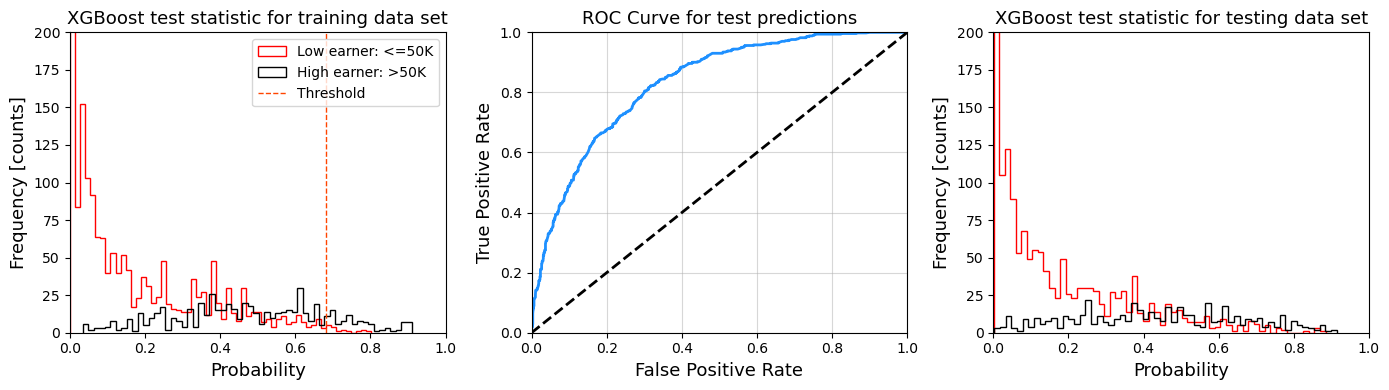

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

ax[0].hist(preds_train['rich'][y_training==0], histtype='step', bins=60, color='red',label='Low earner: <=50K')
ax[0].hist(preds_train['rich'][y_training==1], histtype='step', bins=60, color='black',label='High earner: >50K')
ax[0].set_ylabel('Frequency [counts]',fontsize=13)
ax[0].set_xlabel('Probability',fontsize=13)
ax[0].set_title('XGBoost test statistic for training data set',fontsize=13)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 200.0])
ax[0].axvline(closest_threshold, color='orangered', linestyle='dashed', linewidth=1, label='Threshold')
ax[0].legend()

### ROC curve
ax[1].plot(fpr, tpr, color='dodgerblue', lw=2)
ax[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
ax[1].set_xlabel('False Positive Rate',fontsize=13)
ax[1].set_ylabel('True Positive Rate',fontsize=13)
ax[1].set_title('ROC Curve for test predictions',fontsize=13)
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].grid(True,alpha=0.5,zorder=0)
ax[1].set_axisbelow(True)


ax[2].hist(preds_test['rich'][y_testing==0], histtype='step', bins=60, color='red')
ax[2].hist(preds_test['rich'][y_testing==1], histtype='step', bins=60, color='black')
ax[2].set_ylabel('Frequency [counts]',fontsize=13)
ax[2].set_xlabel('Probability',fontsize=13)
ax[2].set_title('XGBoost test statistic for testing data set',fontsize=13)
ax[2].set_xlim([0.0, 1.0])
ax[2].set_ylim([0.0, 200.0])

plt.tight_layout()
plt.savefig('Problem1_Fig1a.pdf')
plt.show()

##### **Problem 1b**

In [13]:
feature_importances = model.feature_importances_

features = ['age', 'education', 'gender', 'hours-per-week']
importances = list(zip(features, feature_importances))

sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")

age: 0.3093
education: 0.3051
gender: 0.2607
hours-per-week: 0.1249


##### **Problem 1c**

In [14]:
data_real = pd.read_csv('earning_potential_real.txt', sep=',',header=0)
data_real_array = data_real.iloc[:,1:] # Get the data (without the id)

In [15]:
preds_real = model.predict_proba(data_real_array)[:,1]
blind_predictions = (preds_real >= closest_threshold).astype(int)

In [16]:
high_earners_ids = data_real['ID'][blind_predictions == 1]
low_earners_ids = data_real['ID'][blind_predictions == 0]

high_earners_ids.to_csv('C:/Users/gusta/Documents/GitHub/AMAS/ProblemSet3/Gustav_Hedemark.high_ID.txt', index=False, header=False)
low_earners_ids.to_csv('C:/Users/gusta/Documents/GitHub/AMAS/ProblemSet3/Gustav_Hedemark.low_ID.txt', index=False, header=False)